实验二 利用随机次梯度方法求解SVM


- 参考如下文献，理解清楚求解SVM的Pegasos算法（随机次梯度方法），并进行算法编程复现

>Shalev-Shwartz S, Singer Y, Srebro N. Pegasos: Primal estimated sub-gradient solver for svm[C]//Proceedings of the 24th international conference on Machine learning. 2007: 807-814.

- 至少在一个真实数据（最好线性可分）上做验证（参考论文实验部分）

- 至少和一个其他求解算法（例如基于对偶的方法）做对比（参考论文中图4和表2）


首先引入必要的package

In [1]:
import random
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用中文黑体
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号
# 使Matplotlib输出矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 18})
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

对训练集进行载入,返回训练数据,train_data['X']为数据,train_data['y']为标签


In [2]:
def load_train_data():
    train_data = loadmat('spamTrain.mat')
    label = []
    for item in train_data['y']:
        if item[0] == 0:
            label.append([-1])
        else:
            label.append([1])
    return np.mat(train_data['X']),np.mat(label)

对测试集进行载入,本实验选取的数据集是垃圾邮件分类的数据集

spamTrain.mat 是一个$4000 \times 1900$的词频向量矩阵的训练集，第一列是label,1代表是垃圾邮件,0代表不是垃圾邮件
其余列为词向量特征

spamTest.mat 是一个$1000\times 1900$的测试集,用于对模型进行检测


In [3]:
def load_test_data():
    test_data = loadmat('spamTest.mat')
    test_label = []
    for item in test_data['ytest']:
        if item[0] == 0:
            test_label.append([-1])
        else:
            test_label.append([1])
    return np.mat(test_data['Xtest']),np.mat(test_label)

定义函数$f(x)=w^Tx+b$

In [4]:
def forward(w,b,x):
    return w*x.T + b

Pegasos算法求解SVM

In [5]:
def svm_pegasos(data, label, lamda, n):
    row, col = np.shape(data)
    w = np.zeros(col)
    b = 0.0
    loss_history = []  # 新增一个列表用于存储损失函数值的历史记录
    w_norm_history = []  # 用于存储每次迭代后 w 的二范数

    for i in range(1, n + 1):
        r = random.randint(0, row - 1)
        eta = 1.0 / (lamda * i)
        predict = forward(w, b, data[r])
        hinge_loss = max(0, 1 - label[r] * predict)
        loss_history.append(hinge_loss)  # 记录损失函数值

        if label[r] * predict < 1:
            w = w - w / i + eta * label[r] * data[r]
            b = b + eta * label[r]
        else:
            w = w - w / i

        # 计算 w 和 b 的二范数并记录
        w_norm = np.linalg.norm(w, ord=2)
        w_norm_history.append(w_norm)

    return w, b, loss_history, w_norm_history


核函数使用线性核

In [6]:
def kernel_function(x_i, x_j):
    # 修改为线性核函数，也可以使用其他核函数
    return np.dot(x_i, x_j)

次梯度法求解SVM

In [7]:
def svm_subgradient(data, label, lamda, n):
    row, col = np.shape(data)
    w = np.zeros(col)
    b = 0.0
    loss_history = []  # 新增一个列表用于存储损失函数值的历史记录
    w_norm_history = []  # 用于存储每次迭代后 w 的二范数

    for i in range(1, n + 1):
        r = random.randint(0, row - 1)
        eta = 1.0 / (lamda * i)
        predict = forward(w, b, data[r])
        hinge_loss = max(0, 1 - label[r] * predict)
        loss_history.append(hinge_loss)  # 记录损失函数值

        # 计算次梯度
        subgradient_w = np.zeros(col)
        subgradient_b = 0.0

        if hinge_loss > 0:
            subgradient_w = -label[r] * data[r]
            subgradient_b = -label[r]

        # 更新权重和偏置
        w = w - eta * subgradient_w
        b = b - eta * subgradient_b

        # 计算 w 和 b 的二范数并记录
        w_norm = np.linalg.norm(w, ord=2)
        w_norm_history.append(w_norm)

    return w, b, loss_history, w_norm_history

在测试集上进行测试

In [8]:
def test(w,b):
    test_data,test_label = load_test_data()
    pre_list = []
    for item in test_data:
        y_pre = forward(w,b,item)
        if y_pre[0][0]>0:
            pre_list.append(1)
        else:
            pre_list.append(-1)
    count = 0
    for i in range(len(pre_list)):
        if(pre_list[i] == test_label[i][0]):
            count += 1
    # print("The accuracy is:",count/len(pre_list))
    return count/len(pre_list),np.array(pre_list),np.array(test_label)


在训练集上使用次梯度法进行训练,默认$\lambda=1,$迭代次数默认为$2000$次

In [9]:
def train_Subgradient(lamda=1,epoch=2000):
    train_data, train_label = load_train_data()
    w,b,loss_history,w_norm_history = svm_subgradient(train_data,train_label,lamda,epoch)
    return w,b,loss_history,w_norm_history


在训练集上使用Pegasos算法进行测试，默认$\lambda=1,$迭代次数默认为$2000$次

函数会返回模型的$w,b$以及每次迭代的损失函数值(用列表存储),$\left\| w^{(k)}-w^{(k-1)} \right\|$表示这一次与上一次之间的迭代相差多少(均用列表存储)

In [10]:
def train_Pegasos(lamda=1,epoch=2000):
    train_data, train_label = load_train_data()
    w,b,loss_history,w_norm_history = svm_pegasos(train_data,train_label,lamda,epoch)
    return w,b,loss_history,w_norm_history

下面进行两组实验对比，分别查看次梯度方法与随机次梯度方法在不同的正则化系数$\lambda=1.0$与$\lambda=1.5$的情况下,模型的预测效果

$\lambda=1.0$

d:\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


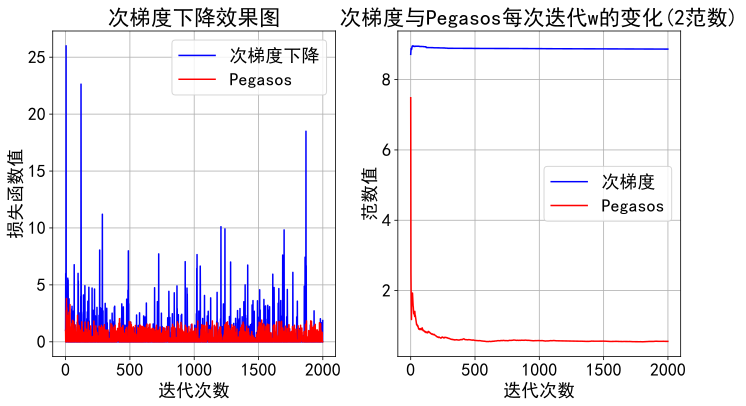

In [16]:
# 分别得到
w1, b1, loss_history1, w1_norm_history = train_Subgradient()
w2, b2, loss_history2, w2_norm_history = train_Pegasos()

# 绘制损失函数值的图表
plt.figure(figsize=(10, 6))

# 绘制 Subgradient 的损失函数图
plt.subplot(1, 2, 1)
plt.plot(loss_history1, label='次梯度下降', color='blue')
plt.plot(loss_history2, label='Pegasos', color='red')
plt.xlabel('迭代次数')
plt.ylabel('损失函数值')
plt.title('次梯度下降效果图')
plt.grid()
plt.legend()


# 绘制 w1_norm_history 与 b1_norm_history 的变化
plt.subplot(1, 2, 2)

plt.plot(w1_norm_history, label='次梯度', color='blue')
plt.plot(w2_norm_history, label='Pegasos', color='red')

plt.xlabel('迭代次数')
plt.ylabel('范数值')
plt.title('次梯度与Pegasos每次迭代w的变化(2范数)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

$\lambda=1.5$

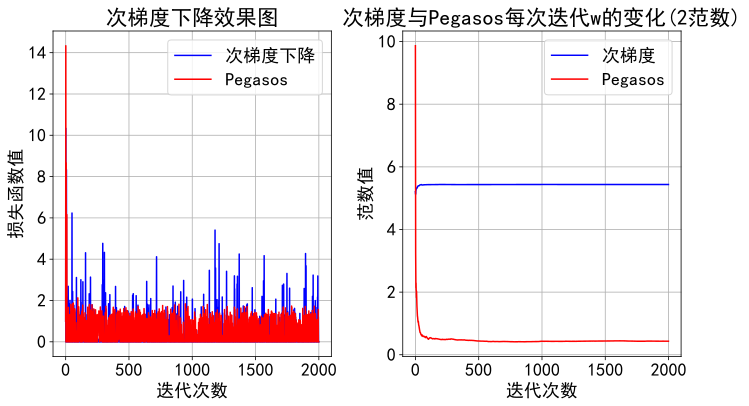

In [17]:
lamda=1.5
epoch=2000

w1, b1, loss_history1, w1_norm_history = train_Subgradient(lamda,epoch=2000)
# 训练 Pegasos
w2, b2, loss_history2, w2_norm_history = train_Pegasos(lamda,epoch)

# 绘制损失函数值的图表
plt.figure(figsize=(10, 6))

# 绘制 Subgradient 的损失函数图
plt.subplot(1, 2, 1)
plt.plot(loss_history1, label='次梯度下降', color='blue')
plt.plot(loss_history2, label='Pegasos', color='red')
plt.xlabel('迭代次数')
plt.ylabel('损失函数值')
plt.title('次梯度下降效果图')
plt.grid()
plt.legend()

# 绘制 w1_norm_history 与 b1_norm_history 的变化
plt.subplot(1, 2, 2)

plt.plot(w1_norm_history, label='次梯度', color='blue')
plt.plot(w2_norm_history, label='Pegasos', color='red')

plt.xlabel('迭代次数')
plt.ylabel('范数值')
plt.title('次梯度与Pegasos每次迭代w的变化(2范数)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

#### PCA降维可视化

由于数据的特征数目较多(1899维),因此为了可视化决策边界,使用PCA进行降维,查看使用次梯度和随机次梯度这两种方法的分类效果

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


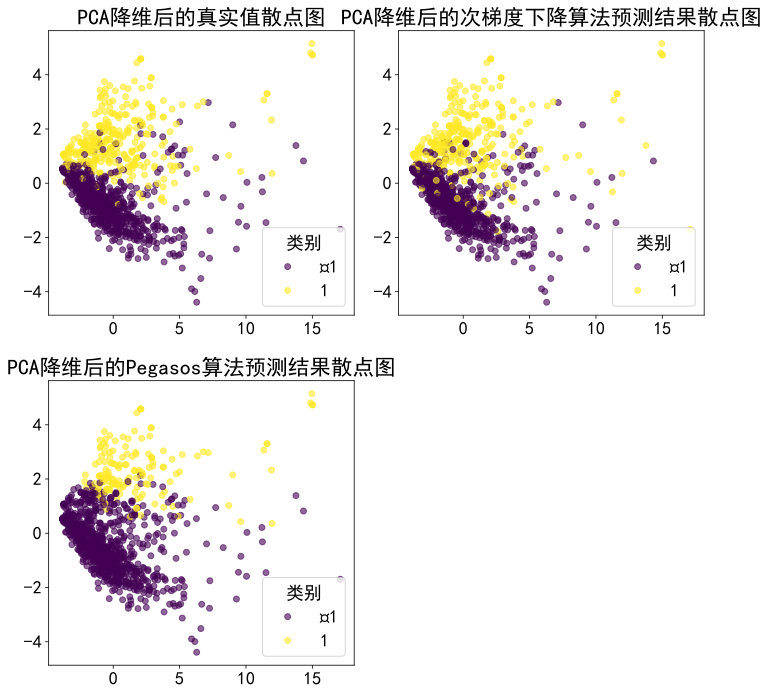

In [18]:
# 获取测试数据和标签
test_data, test_label = load_test_data()
_, y_pred_subgradient, y_test = test(w1, b1)  # 使用 Subgradient 模型的预测结果
_, y_pred_pegasos, y_test = test(w2, b2)  # 使用 Pegasos 模型的预测结果

# 使用 PCA 进行降维
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(np.array(test_data, dtype=object))

# 绘制散点图
plt.figure(figsize=(10, 10))

# 绘制真实类别
plt.subplot(2, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='viridis', marker='o', alpha=0.6)
plt.title('PCA降维后的真实值散点图')
plt.legend(*scatter.legend_elements(), title='类别')

# 绘制预测类别（Subgradient）
plt.subplot(2, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_subgradient, cmap='viridis', marker='o', alpha=0.6)
plt.title('PCA降维后的次梯度下降算法预测结果散点图')
plt.legend(*scatter.legend_elements(), title='类别')

# 绘制预测类别（Pegasos）
plt.subplot(2, 2, 3)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_pegasos, cmap='viridis', marker='o', alpha=0.6)
plt.title('PCA降维后的Pegasos算法预测结果散点图')
plt.legend(*scatter.legend_elements(), title='类别')

plt.tight_layout()
plt.show()

#### 混淆矩阵评价

评价两种方法好坏,使用混淆矩阵的方法

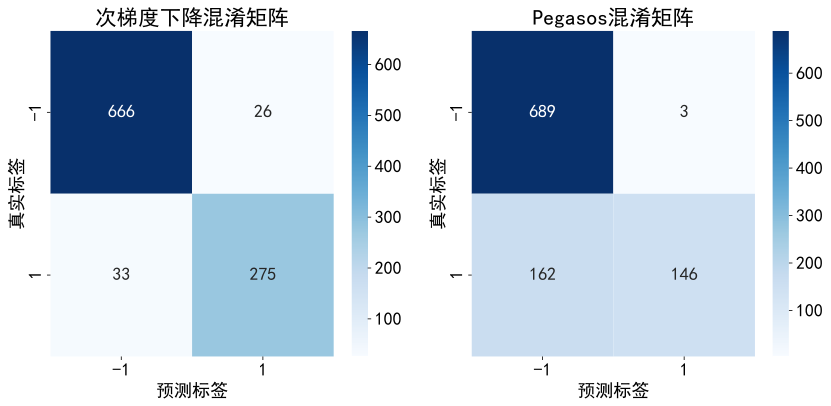

In [19]:
# 计算混淆矩阵
cm_subgradient = confusion_matrix(y_test, y_pred_subgradient)
cm_pegasos = confusion_matrix(y_test, y_pred_pegasos)
# 绘制混淆矩阵图
plt.figure(figsize=(12, 6))
# 次梯度下降混淆矩阵
plt.subplot(1, 2, 1)
sns.heatmap(cm_subgradient, annot=True, fmt='d', cmap='Blues', xticklabels=['-1', '1'], yticklabels=['-1', '1'])
plt.title('次梯度下降混淆矩阵')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
# Pegasos混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(cm_pegasos, annot=True, fmt='d', cmap='Blues', xticklabels=['-1', '1'], yticklabels=['-1', '1'])
plt.title('Pegasos混淆矩阵')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.tight_layout()
plt.show()


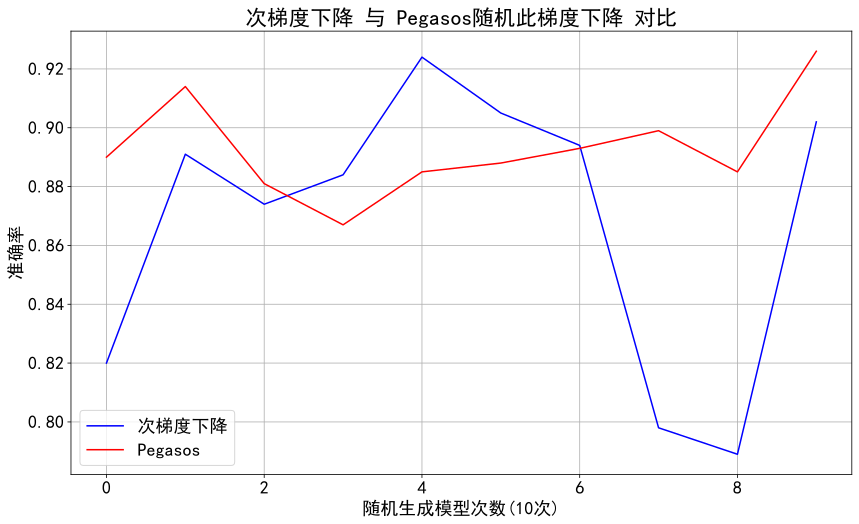

次梯度下降法随机10次的准确率:[0.82, 0.891, 0.874, 0.884, 0.924, 0.905, 0.894, 0.798, 0.789, 0.902]
Pegasos随机10次的准确率[0.89, 0.914, 0.881, 0.867, 0.885, 0.888, 0.893, 0.899, 0.885, 0.926]


In [20]:
if __name__ == '__main__':
    accuracy_history_subgradient = []
    accuracy_history_pegasos = []
    times=100
    lamda_1=1.5
    lamda_2=1.0
    epoch=1500
    for i in range(times):

        # 训练 Subgradient
        w1, b1, loss_history1,_ = train_Subgradient(lamda_1,epoch)
        # 训练 Pegasos
        w2, b2, loss_history2,_ = train_Pegasos(lamda_2,epoch)
        
        accuracy_subgradient,_,_ =test(w1, b1)
        accuracy_pegasos,_,_ = test(w2, b2)
        accuracy_history_subgradient.append(accuracy_subgradient)
        accuracy_history_pegasos.append(accuracy_pegasos)

        # 可视化
    plt.figure(figsize=(14, 8))    
    plt.plot(accuracy_history_subgradient, label='次梯度下降', color='blue')
    plt.plot(accuracy_history_pegasos, label='Pegasos', color='red')

    plt.xlabel(f'随机生成模型次数({times}次)')
    plt.ylabel('准确率')
    plt.title('次梯度下降 与 Pegasos随机此梯度下降 对比')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"次梯度下降法随机{times}次的准确率:{accuracy_history_subgradient}")
    print(f"Pegasos随机{times}次的准确率{accuracy_history_pegasos}")
